In [27]:
import torch
import torchvision
import numpy as np
from pathlib import Path
from glob import glob
import cv2 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from PIL import Image
import scipy.io
from tqdm import trange, tqdm
from random import shuffle
import pickle

from src.alexnet import model as alexnet_model, preprocess as alexnet_preprocess
from data.labels import labels

from src.simba import SimBA_Attack

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Device used: {device}")

Device used: cuda:0


In [28]:
labels_path = Path("./results/used_labels.txt")
image_names_path = Path("./results/used_images.txt")
images_subset_path = Path("./results/subset_used/")

In [29]:
def get_names_labels():
    with open(labels_path, "r") as f:
        lines = f.readlines()
    labels = [line.rstrip() for line in lines]
    
    with open(image_names_path, "r") as f:
        lines = f.readlines()
    names = [line.rstrip() for line in lines]
    return labels, names
        
LABELS, NAMES = get_names_labels()
PATHS = ["./results/subset_used/" + p for p in NAMES]

In [30]:
def get_alexnet_img(path):
    img = Image.open(path)
    return alexnet_preprocess(img)

def get_img(path):
    img = Image.open(path)
    return img

def find_correctly_classified(model, paths, labels):
    """
        Shuffle paths / labels together so we get a different set of inputs
        each time.
        
        Ref:
        https://www.geeksforgeeks.org/python-shuffle-two-lists-with-same-order/
    """
        
    model.eval()
        
    correct = []
    for i in trange(len(paths)):
        this_path = paths[i]
        
        try:
            this_image = get_alexnet_img(this_path)
            
            with torch.no_grad():
                logits = model(this_image.view(-1,3,224,224))
                
            preds = torch.nn.functional.softmax(logits, dim=1)
        except:
            continue
            
        y_hat = int(torch.argmax(preds))
        
        """
            Found that inputs that model was very confident on required
            many adversarial iterations, so picked those that it is reason-
            ably confident on but is somewhat close to the decision boundary."""
        if y_hat == int(labels[i]):
            correct += [[this_path, y_hat]]
            
    return correct

In [31]:
# n_correct = find_correctly_classified(alexnet_model, PATHS, LABELS)
# print(len(n_correct))

In [32]:
# grab datastructure w/ perturbations from pickle
with open("./results/sorted_outputs.p", "rb") as f:
    out_vecs_read = pickle.load(f)
    
print(len(out_vecs_read))

987


In [33]:
count_hist = []
iter_hist = []
norms_hist = []

for vec in out_vecs_read:
    img_path, x, y, history, count, iters = vec
    count_hist.append(count)
    iter_hist.append(iters)
    norms_hist.append(np.linalg.norm(history))

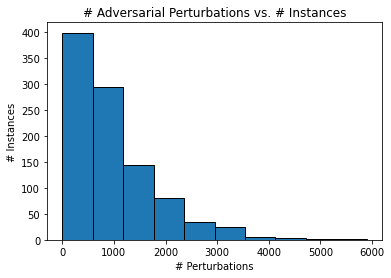

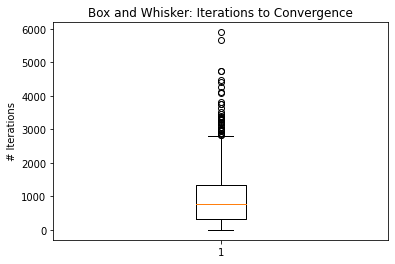

Max: 5901
Avg: 974.0597771023303
Std: 852.5127728280709
Med: 778.0
Min: 2


In [34]:
plt.hist(count_hist, edgecolor="black")
plt.title("# Adversarial Perturbations vs. # Instances")
plt.xlabel("# Perturbations")
plt.ylabel("# Instances")
plt.show()

plt.boxplot(count_hist)
plt.title("Box and Whisker: Iterations to Convergence")
plt.ylabel("# Iterations")
plt.show()

print(f"Max: {np.max(count_hist)}")
print(f"Avg: {np.mean(count_hist)}")
print(f"Std: {np.std(count_hist)}")
print(f"Med: {np.median(count_hist)}")
print(f"Min: {np.min(count_hist)}")

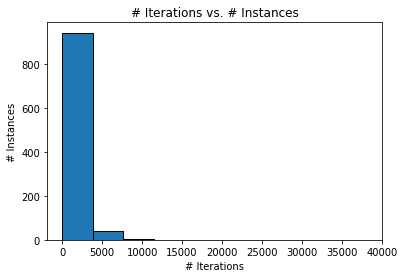

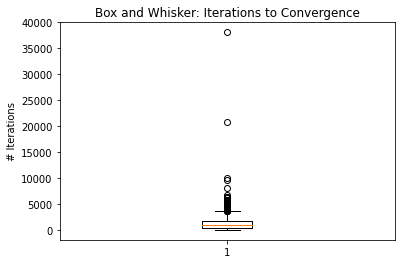

Max: 38114
Avg: 1329.6717325227964
Std: 1784.4693209715572
Med: 972.0
Min: 2


In [35]:
plt.hist(iter_hist, edgecolor="black")
plt.title("# Iterations vs. # Instances")
plt.xlabel("# Iterations")
plt.ylabel("# Instances")
plt.show()

plt.boxplot(iter_hist)
plt.title("Box and Whisker: Iterations to Convergence")
plt.ylabel("# Iterations")
plt.show()

print(f"Max: {np.max(iter_hist)}")
print(f"Avg: {np.mean(iter_hist)}")
print(f"Std: {np.std(iter_hist)}")
print(f"Med: {np.median(iter_hist)}")
print(f"Min: {np.min(iter_hist)}")

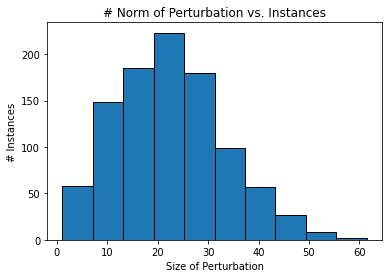

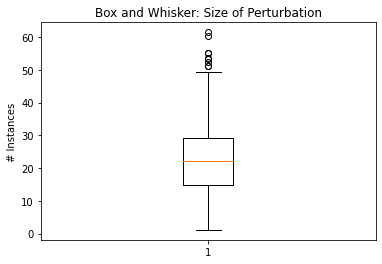

Max: 61.454349517822266
Avg: 22.601285934448242
Std: 10.610371589660645
Med: 22.314123153686523
Min: 1.1313709020614624


In [36]:
plt.hist(norms_hist, edgecolor="black")
plt.title("# Norm of Perturbation vs. Instances")
plt.xlabel("Size of Perturbation")
plt.ylabel("# Instances")
plt.show()

plt.boxplot(norms_hist)
plt.title("Box and Whisker: Size of Perturbation")
plt.ylabel("# Instances")
plt.show()

print(f"Max: {np.max(norms_hist)}")
print(f"Avg: {np.mean(norms_hist)}")
print(f"Std: {np.std(norms_hist)}")
print(f"Med: {np.median(norms_hist)}")
print(f"Min: {np.min(norms_hist)}")

In [37]:
print(f"Success rate: {len(out_vecs_read) / 1000}")

Success rate: 0.987


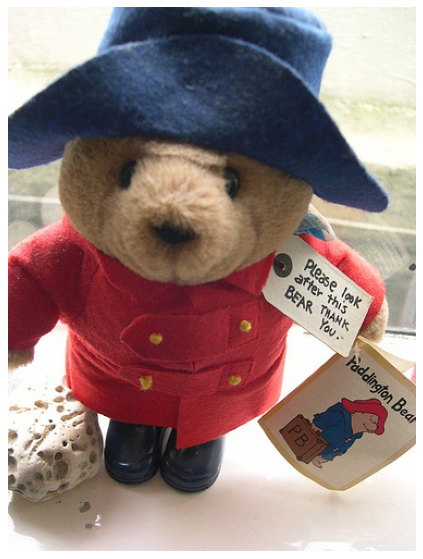

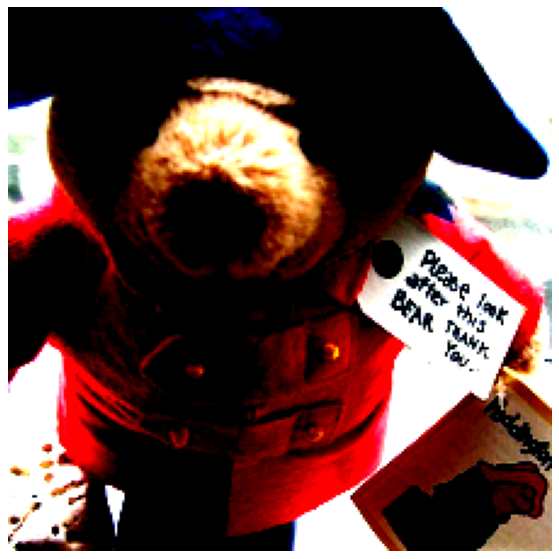

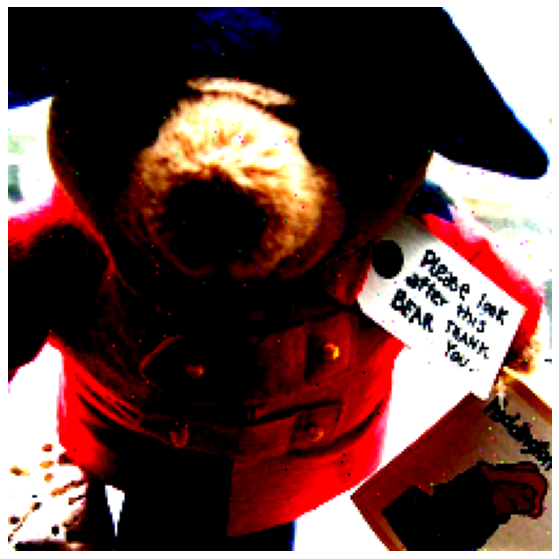

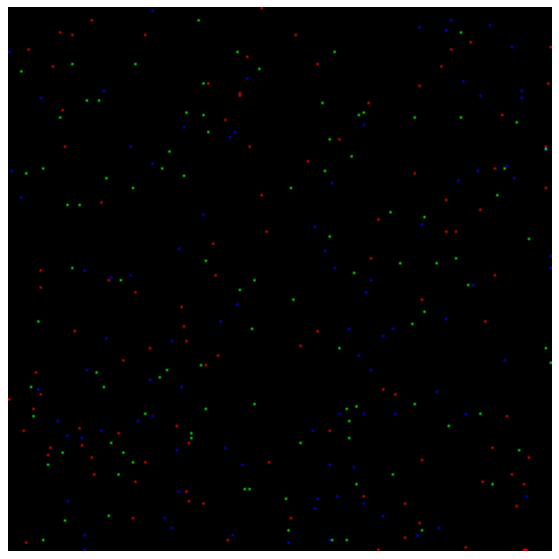

In [54]:
NUM = 2

figure(figsize=(11, 9), dpi=80)
plt.imshow(get_img(PATHS[NUM]))
plt.axis('off')
plt.show()

figure(figsize=(11, 9), dpi=80)
plt.imshow(get_alexnet_img(PATHS[NUM]).permute(1,2,0).clamp(0,1))
plt.axis('off')
plt.show()

figure(figsize=(11, 9), dpi=80)
plt.imshow(out_vecs_read[NUM][1].permute(1,2,0).clamp(0,1))
plt.axis('off')
plt.show()

figure(figsize=(11, 9), dpi=80)
plt.imshow(out_vecs_read[NUM][3].reshape(224,224,3).clamp(0,1))
plt.axis('off')
plt.show()